In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/MLsecurity_project") 

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
# import os
# os.chdir("drive/MLsecurity_project") 
import keras
import sys
import h5py
import numpy as np
from keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
import heapq

# Prepare Data

In [ ]:
# get data
sunglasses_filename = "data/sunglasses_poisoned_data.h5"
anonymous_1_filename = "data/anonymous_1_poisoned_data.h5"
muleye_filename = "data/Multi/eyebrows_poisoned_data.h5"
mullip_filename = "data/Multi/lipstick_poisoned_data.h5"
mulsun_filename = "data/Multi/sunglasses_poisoned_data.h5"
vali_filename = "data/clean_validation_data.h5"
test_filename = "data/clean_test_data.h5"
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

In [ ]:
# sunglasses data
x_sun, y_sun = data_loader(sunglasses_filename)
x_sun = data_preprocess(x_sun)
# # anonymous 1 data
x_ano1, y_ano1 = data_loader(anonymous_1_filename)
x_ano1 = data_preprocess(x_ano1)
# multi_trigger data
x_me, y_me = data_loader(muleye_filename)
x_me = data_preprocess(x_me)
x_ms, y_ms = data_loader(mulsun_filename)
x_ms = data_preprocess(x_ms)
x_ml, y_ml = data_loader(mullip_filename)
x_ml = data_preprocess(x_ml)
# validation clean data
x_val, y_val = data_loader(vali_filename)
x_val = data_preprocess(x_val)
# test clean data
x_test, y_test = data_loader(test_filename)
x_test = data_preprocess(x_test)

# Prepare Model and Fine-pruning setting

In [ ]:
# get activation result of last convalutional layer
def act_last_layer(model, x):
  # bd_model = keras.models.load_model(sun_bd_filename)
  layer_outputs = model.layers[6].output
  layer_outputs_2 = model.layers[7].output
  
  model_act = Model(inputs= model.input, outputs=layer_outputs)
  activations = model_act.predict(x)
  model_act_2 = Model(inputs= model.input, outputs=layer_outputs_2)
  activations_2 = model_act_2.predict(x)
  return activations, activations_2

In [ ]:
# only prune last layer
def pru_mask(activations, fra, fra_mask):
  act = np.sum(activations,0)
  act = act.reshape(-1)
  n_pru = int(len(act)*fra)
  pru = np.argpartition(act,n_pru)[:n_pru]
  mask = np.ones(act.shape)
  for i in pru:
      mask[i] = fra_mask
  return mask 

def Net(mask, mask_2):
	# define input
  x = keras.Input(shape=(55, 47, 3), name='input')
  # feature extraction
  conv_1 = keras.layers.Conv2D(20, (4, 4), activation='relu', name='conv_1')(x)
  pool_1 = keras.layers.MaxPooling2D((2, 2), name='pool_1')(conv_1)
  conv_2 = keras.layers.Conv2D(40, (3, 3), activation='relu', name='conv_2')(pool_1)
  pool_2 = keras.layers.MaxPooling2D((2, 2), name='pool_2')(conv_2)
  conv_3 = keras.layers.Conv2D(60, (3, 3), activation='relu', name='conv_3')(pool_2)
  pool_3 = keras.layers.MaxPooling2D((2, 2), name='pool_3')(conv_3)
  # first interpretation model
  flat_1 = keras.layers.Flatten()(pool_3)
  pru = keras.layers.Lambda(lambda x:x*mask)(flat_1)
  fc_1 = keras.layers.Dense(160, name='fc_1')(pru)
  # second interpretation model
  conv_4 = keras.layers.Conv2D(80, (2, 2), activation='relu', name='conv_4')(pool_3)
  flat_2 = keras.layers.Flatten()(conv_4)
  pru_2 = keras.layers.Lambda(lambda x:x*mask_2)(flat_2)
  fc_2 = keras.layers.Dense(160, name='fc_2')(pru_2)
  # merge interpretation
  merge = keras.layers.Add()([fc_1, fc_2])
  add_1 = keras.layers.Activation('relu')(merge)
  drop = keras.layers.Dropout(0.5)
  # output
  y_hat = keras.layers.Dense(1283, activation='softmax', name='output')(add_1)
  model = keras.Model(inputs=x, outputs=y_hat)
  # summarize layers
  #print(model.summary())
  # plot graph
  #plot_model(model, to_file='model_architecture.png')

  return model

def get_acc(model, x, y):
  lab = np.argmax(model.predict(x), axis=1)
  accu = np.mean(np.equal(lab, y))*100
  return accu

In [ ]:
#setting fine-prune
def accu_fine_prune(act, act2, fras, fra_mask,x_poi,y_poi,filename):
  accu_pru_val = []
  accu_pru_test = []
  accu_pru_poi = []
  accu_fp_val = []
  accu_fp_test = []
  accu_fp_poi = []
  # mask = pru_mask(activations_2, i, fra_mask)
  # mask_2 = pru_mask(activations, i, fra_mask)
  for i in fras:
    mask = pru_mask(act, i, fra_mask)
    mask_2 = pru_mask(act2, i, fra_mask)
    fp_model = Net(mask, mask_2)
    fp_model.load_weights(filename, by_name=True)
    # get accuracy after prune before fine tune
    fp_poi_accu = get_acc(fp_model, x_poi, y_poi)
    fp_val_accu = get_acc(fp_model, x_val, y_val)
    fp_test_accu = get_acc(fp_model, x_test, y_test)
    res = fp_model.predict(x_poi)
    print('res of poison data(prune):', res)
    accu_pru_val.append(fp_val_accu)
    accu_pru_test.append(fp_test_accu)
    accu_pru_poi.append(fp_poi_accu)
    # compile model 
    fp_model.compile(optimizer=keras.optimizers.SGD(1e-3,momentum=0.9),  # Very low learning rate
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    fp_model.fit(x_val, y_val, epochs=20, verbose=0)
    # bd_model.save(str(i)+'.h5')
    # print(0)
    # fp_model.save('mullip_'+str(i)+'.h5')
    # print(1)
    res = fp_model.predict(x_poi)
    print('res of poison data(fine-prune):', res)
    # get accuracy after fine-pruning 
    fp_poi_accu = get_acc(fp_model, x_poi, y_poi)
    fp_val_accu = get_acc(fp_model, x_val, y_val)
    fp_test_accu = get_acc(fp_model, x_test, y_test)
    accu_fp_val.append(fp_val_accu)
    accu_fp_test.append(fp_test_accu)
    accu_fp_poi.append(fp_poi_accu)

  return accu_pru_val, accu_pru_test, accu_pru_poi, accu_fp_val, accu_fp_test, accu_fp_poi

In [ ]:
# save model based on accuracy
def save_model(act, act2, fra, fra_mask,filename, save_name):
 
  mask = pru_mask(act, fra, fra_mask)
  mask_2 = pru_mask(act2, fra, fra_mask)
  fp_model = Net(mask, mask_2)
  fp_model.load_weights(filename, by_name=True)
  fp_model.compile(optimizer=keras.optimizers.SGD(1e-3,momentum=0.9),  # Very low learning rate
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  fp_model.fit(x_val, y_val, epochs=20, verbose=0)
  
  fp_model.save(save_name+'.h5')
  return 

# BadNet1:Sunglasses_BD_NET

In [ ]:
# get badnet and weight
sun_weight_filename = "model/sunglasses_bd_weights.h5"
sun_bd_filename = "model/sunglasses_bd_net.h5"

bd_model = keras.models.load_model(sun_bd_filename)

In [ ]:
# hyper-parameter, fra_mask = 0
fras = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
fra_mask = 0
act_sun, act_sun2 = act_last_layer(bd_model, x_val)
accu_pru_val, accu_pru_test, accu_pru_poi, accu_fp_val, accu_fp_test, accu_fp_poi= accu_fine_prune(act_sun, act_sun2, fras, fra_mask,x_sun,y_sun, sun_bd_filename)

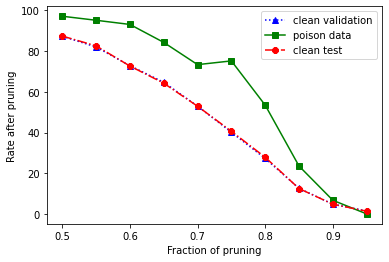

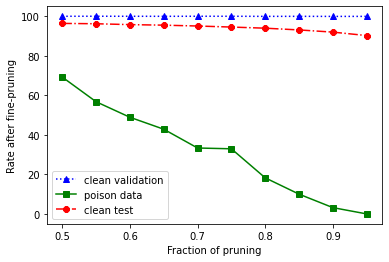

accuracy after prune(validation data): [87.2954014029618, 82.02996449294189, 72.8414306746341, 64.68346756733351, 52.95747813284836, 40.14029618082619, 27.2451719061228, 12.574694725902832, 4.771802199705552, 1.4462630986403395]
accuracy after prune(poison data):  [97.13951675759938, 95.1597817614965, 93.10989867498051, 84.28682774746687, 73.35931410756041, 75.19095869056898, 53.44505066250974, 23.522992985190957, 6.703039750584567, 0.0]
accuracy after prune(test data): [87.40452065471551, 82.57989088074824, 72.66562743569759, 64.24006235385814, 52.90724863600935, 40.60015588464536, 27.84099766173032, 12.455183164458301, 4.777864380358535, 1.332813717848792]
accuracy after fine-prune(validation data): [99.96535896769724, 99.98267948384861, 99.96535896769724, 99.94803845154586, 99.97401922577292, 99.97401922577292, 99.92205767731879, 99.93937819347016, 99.9047371611674, 99.91339741924308]
accuracy after fine-prune(poison data):  [69.2049883086516, 56.74201091192518, 48.89321901792674, 4

In [ ]:
# for 0 mask
plt.plot(fras,accu_pru_val, color='b',marker = "^",linestyle = ':')
plt.plot(fras,accu_pru_poi, color='g',marker = 's')
plt.plot(fras,accu_pru_test, color='r', marker = '8', linestyle='-.')
plt.legend(['clean validation','poison data','clean test'],loc= 'best')
plt.xlabel("Fraction of pruning")
plt.ylabel('Rate after pruning')
plt.savefig('sun_rate_prune.png')
plt.show()

plt.plot(fras,accu_fp_val, color='b',marker = "^",linestyle = ':')
plt.plot(fras,accu_fp_poi, color='g',marker = 's')
plt.plot(fras,accu_fp_test, color='r',marker = '8', linestyle='-.')
plt.legend(['clean validation','poison data','clean test'],loc= 'best')
plt.xlabel("Fraction of pruning")
plt.ylabel('Rate after fine-pruning')
plt.savefig('sun_rate_fp.png')
plt.show()

print('accuracy after prune(validation data):', accu_pru_val)
print('accuracy after prune(poison data): ',accu_pru_poi)
print('accuracy after prune(test data):',accu_pru_test)
print('accuracy after fine-prune(validation data):', accu_fp_val)
print('accuracy after fine-prune(poison data): ',accu_fp_poi)
print('accuracy after fine-prune(test data):',accu_fp_test)
# data = np.cstack

In [ ]:
save_model(act_sun, act_sun2, 0.9, 0,sun_weight_filename,'sun_bd_repaired')

In [ ]:
sun_repaired_model = keras.models.load_model('sun_bd_repaired.h5')
sun_repaired_model.evaluate(x_test,y_test)

401/401 [==============================] - 8s 3ms/step - loss: 0.5447 - accuracy: 0.9213


[0.5447450280189514, 0.9212782382965088]

# BadNet: Anonymous 1

In [ ]:
# get badnet and weight
ano1_bd_filename = "model/anonymous_1_bd_net.h5"
ano1_weight_filename = "model/anonymous_1_bd_weights.h5"
ano1_model = keras.models.load_model(ano1_bd_filename)

# anonymous 1 data
x_ano1, y_ano1 = data_loader(anonymous_1_filename)
x_ano1 = data_preprocess(x_ano1)


In [ ]:
# hyper-parameter, fra_mask = 0
fras = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
fra_mask = 0
act_ano1, act_ano12 = act_last_layer(ano1_model, x_val)
accu_pru_val, accu_pru_test, accu_pru_poi, accu_fp_val, accu_fp_test, accu_fp_poi= accu_fine_prune(act_ano1, act_ano12, fras, fra_mask,x_ano1,y_ano1, ano1_weight_filename)


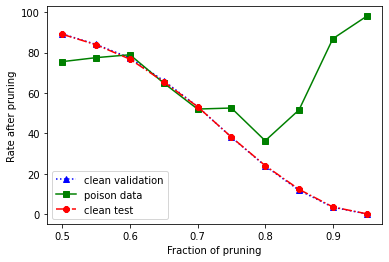

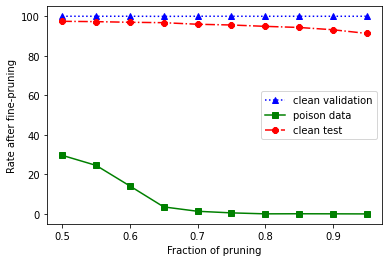

accuracy after prune(validation data): [89.26127998614358, 84.03048410842644, 77.379405906296, 66.08642937559539, 53.321208972027364, 38.113795791114576, 23.92829306313328, 11.89053433792327, 3.4987442625790246, 0.19052567766519443]
accuracy after prune(poison data):  [75.53585346843336, 77.51363990646921, 78.9360872954014, 64.92595479345285, 52.07521434138738, 52.58183943881528, 36.39906469212782, 51.65627435697584, 86.87646141855028, 97.99298519095869]
accuracy after prune(test data): [89.08028059236165, 83.88152766952454, 76.75759937646141, 65.5650818394388, 53.25798908807482, 38.20732657833204, 24.084177708495712, 12.361652377240842, 3.6399064692127823, 0.2572096648480125]
accuracy after fine-prune(validation data): [99.98267948384861, 99.96535896769724, 99.98267948384861, 99.92205767731879, 99.98267948384861, 99.97401922577292, 99.96535896769724, 99.97401922577292, 99.96535896769724, 99.97401922577292]
accuracy after fine-prune(poison data):  [29.637568199532343, 24.56157443491816

In [ ]:
# for 0 mask
plt.plot(fras,accu_pru_val, color='b',marker = "^",linestyle = ':')
plt.plot(fras,accu_pru_poi, color='g',marker = 's')
plt.plot(fras,accu_pru_test, color='r', marker = '8', linestyle='-.')
plt.legend(['clean validation','poison data','clean test'],loc= 'best')
plt.xlabel("Fraction of pruning")
plt.ylabel('Rate after pruning')
plt.savefig('ano1_rate_prune.png')
plt.show()

plt.plot(fras,accu_fp_val, color='b',marker = "^",linestyle = ':')
plt.plot(fras,accu_fp_poi, color='g',marker = 's')
plt.plot(fras,accu_fp_test, color='r',marker = '8', linestyle='-.')
plt.legend(['clean validation','poison data','clean test'],loc= 'best')
plt.xlabel("Fraction of pruning")
plt.ylabel('Rate after fine-pruning')
plt.savefig('ano1_rate_fp.png')
plt.show()

print('accuracy after prune(validation data):', accu_pru_val)
print('accuracy after prune(poison data): ',accu_pru_poi)
print('accuracy after prune(test data):',accu_pru_test)
print('accuracy after fine-prune(validation data):', accu_fp_val)
print('accuracy after fine-prune(poison data): ',accu_fp_poi)
print('accuracy after fine-prune(test data):',accu_fp_test)

In [ ]:
save_model(act_ano1, act_ano12, 0.8, 0,ano1_weight_filename,'ano1_bd_repaired')

In [ ]:
ano1_repaired_model = keras.models.load_model('ano1_bd_repaired.h5')
ano1_repaired_model.evaluate(x_test,y_test)

401/401 [==============================] - 1s 3ms/step - loss: 0.3274 - accuracy: 0.9503


[0.3273594379425049, 0.950272798538208]

# BadNet: Anonymous 2

In [ ]:
# get badnet and weight
ano2_bd_filename = "model/anonymous_2_bd_net.h5"
ano2_weight_filename = "model/anonymous_2_bd_weights.h5"
ano2_model = keras.models.load_model(ano2_bd_filename)

In [ ]:
#without poison data
def accu_fine_prune2(act, act2, fras, fra_mask,filename):
  accu_pru_val = []
  accu_pru_test = []
  # accu_pru_poi = []
  accu_fp_val = []
  accu_fp_test = []
  # accu_fp_poi = []
  # mask = pru_mask(activations_2, i, fra_mask)
  # mask_2 = pru_mask(activations, i, fra_mask)
  for i in fras:
    mask = pru_mask(act, i, fra_mask)
    mask_2 = pru_mask(act2, i, fra_mask)
    fp_model = Net(mask, mask_2)
    fp_model.load_weights(filename, by_name=True)
    # get accuracy after prune before fine tune
    # fp_poi_accu = get_acc(fp_model, x_poi, y_poi)
    fp_val_accu = get_acc(fp_model, x_val, y_val)
    fp_test_accu = get_acc(fp_model, x_test, y_test)
    accu_pru_val.append(fp_val_accu)
    accu_pru_test.append(fp_test_accu)
    # accu_pru_poi.append(fp_poi_accu)
    # compile model 
    fp_model.compile(optimizer=keras.optimizers.SGD(1e-3,momentum=0.9),  # Very low learning rate
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    fp_model.fit(x_val, y_val, epochs=20, verbose=0)
    # get accuracy after fine-pruning 
    # fp_poi_accu = get_acc(fp_model, x_poi, y_poi)
    fp_val_accu = get_acc(fp_model, x_val, y_val)
    fp_test_accu = get_acc(fp_model, x_test, y_test)
    accu_fp_val.append(fp_val_accu)
    accu_fp_test.append(fp_test_accu)
    # accu_fp_poi.append(fp_poi_accu)

  return accu_pru_val, accu_pru_test, accu_fp_val, accu_fp_test

In [ ]:
# hyper-parameter, fra_mask = 0
fras = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
fra_mask = 0
act_ano2, act_ano22 = act_last_layer(ano2_model, x_val)
accu_pru_val, accu_pru_test, accu_fp_val, accu_fp_test= accu_fine_prune2(act_ano2, act_ano22, fras, fra_mask,ano2_weight_filename)


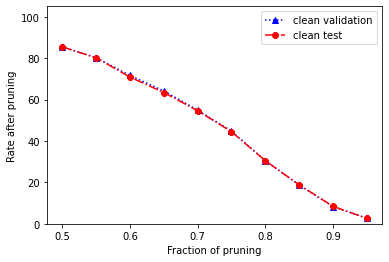

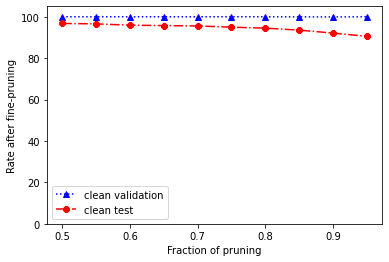

accuracy after prune(validation data): [85.41612540053694, 80.24595132934962, 71.6376548021131, 64.18117259894345, 54.923356716030135, 44.764873993245, 30.51008920065818, 18.79276002424872, 8.296527236511649, 2.7453018099939377]
accuracy after prune(test data): [85.43257989088075, 80.14809041309431, 70.87295401402962, 63.39049103663289, 54.614185502727985, 44.50506625097428, 30.498830865159782, 18.862042088854245, 8.48791893998441, 2.665627435697584]
accuracy after fine-prune(validation data): [99.96535896769724, 99.96535896769724, 99.97401922577292, 99.98267948384861, 99.96535896769724, 99.98267948384861, 99.96535896769724, 99.93937819347016, 99.89607690309171, 99.97401922577292]
accuracy after fine-prune(test data): [96.75759937646143, 96.53936087295402, 95.91582229150428, 95.71317225253313, 95.53390491036633, 94.96492595479346, 94.48168355416992, 93.53078721745908, 92.09664848012471, 90.54559625876851]


In [ ]:
# for 0 mask
plt.plot(fras,accu_pru_val, color='b',marker = "^",linestyle = ':')
# plt.plot(fras,accu_pru_poi, color='g',marker = 's')
plt.plot(fras,accu_pru_test, color='r', marker = '8', linestyle='-.')
plt.legend(['clean validation','clean test'],loc= 'best')
plt.xlabel("Fraction of pruning")
plt.ylabel('Rate after pruning')
plt.ylim(0,105)
plt.savefig('ano2_rate_prune.png')
plt.show()

plt.plot(fras,accu_fp_val, color='b',marker = "^",linestyle = ':')
# plt.plot(fras,accu_fp_poi, color='g',marker = 's')
plt.plot(fras,accu_fp_test, color='r',marker = '8', linestyle='-.')
plt.legend(['clean validation','clean test'],loc= 'best')
plt.xlabel("Fraction of pruning")
plt.ylabel('Rate after fine-pruning')
plt.ylim(0,105)
plt.savefig('ano2_rate_fp.png')
plt.show()

print('accuracy after prune(validation data):', accu_pru_val)
# print('accuracy after prune(poison data): ',accu_pru_poi)
print('accuracy after prune(test data):',accu_pru_test)
print('accuracy after fine-prune(validation data):', accu_fp_val)
# print('accuracy after fine-prune(poison data): ',accu_fp_poi)
print('accuracy after fine-prune(test data):',accu_fp_test)

In [ ]:
save_model(act_ano2, act_ano22, 0.8, 0,ano2_weight_filename,'ano2_bd_repaired')

In [ ]:
ano2_repaired_model = keras.models.load_model('ano2_bd_repaired.h5')
ano2_repaired_model.evaluate(x_test,y_test)

401/401 [==============================] - 1s 3ms/step - loss: 0.3231 - accuracy: 0.9433


[0.32311344146728516, 0.9432579874992371]

# BadNet: Multi_trigger_Multi_target

In [ ]:
# get badnet and weight
mul_bd_filename = "model/multi_trigger_multi_target_bd_net.h5"
mul_weight_filename = "model/multi_trigger_multi_target_bd_weights.h5"
mul_model = keras.models.load_model(mul_bd_filename)
# get data
# multi_trigger data
x_me, y_me = data_loader(muleye_filename)
x_me = data_preprocess(x_me)
x_ms, y_ms = data_loader(mulsun_filename)
x_ms = data_preprocess(x_ms)
x_ml, y_ml = data_loader(mullip_filename)
x_ml = data_preprocess(x_ml)

In [ ]:
# hyper-parameter, fra_mask = 0
fras = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
fra_mask = 0
act_mul, act_mul2 = act_last_layer(mul_model, x_val)
accu_pru_val, accu_pru_test, accu_pru_poi, accu_fp_val, accu_fp_test, accu_fp_poi= accu_fine_prune(act_mul, act_mul2, fras, fra_mask,x_me,y_me, mul_weight_filename)


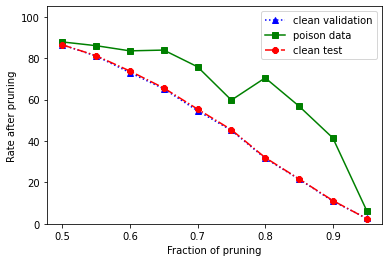

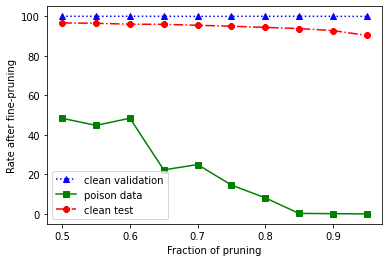

accuracy after prune(validation data): [86.40339482116566, 81.00805404001039, 73.01463583614792, 65.18576253572357, 54.5856066510782, 45.10262405819693, 31.609941976270896, 21.55538235039404, 10.929245691521608, 2.6153979388585777]
accuracy after prune(poison data):  [87.82151208106002, 86.00935307872174, 83.51519875292284, 83.88542478565861, 75.80865159781762, 59.72330475448169, 70.46960249415433, 56.81995323460639, 41.44583008573656, 6.410756040530008]
accuracy after prune(test data): [86.43024162120031, 81.1925175370226, 73.76461418550274, 65.58846453624318, 55.39360872954015, 45.4169914263445, 31.97194076383476, 21.683554169914263, 11.215900233826968, 2.509742790335152]
accuracy after fine-prune(validation data): [99.98267948384861, 99.95669870962155, 99.98267948384861, 99.96535896769724, 99.91339741924308, 99.93071793539447, 99.97401922577292, 99.97401922577292, 99.93071793539447, 99.89607690309171]
accuracy after fine-prune(poison data):  [48.33398285268901, 44.80709275136399, 48

In [ ]:
# for 0 mask
plt.plot(fras,accu_pru_val, color='b',marker = "^",linestyle = ':')
plt.plot(fras,accu_pru_poi, color='g',marker = 's')
plt.plot(fras,accu_pru_test, color='r', marker = '8', linestyle='-.')
plt.legend(['clean validation','poison data','clean test'],loc= 'best')
plt.xlabel("Fraction of pruning")
plt.ylabel('Rate after pruning')
plt.ylim(0,105)
plt.savefig('mul_rate_prune.png')
plt.show()

plt.plot(fras,accu_fp_val, color='b',marker = "^",linestyle = ':')
plt.plot(fras,accu_fp_poi, color='g',marker = 's')
plt.plot(fras,accu_fp_test, color='r',marker = '8', linestyle='-.')
plt.legend(['clean validation','poison data','clean test'],loc= 'best')
plt.xlabel("Fraction of pruning")
plt.ylabel('Rate after fine-pruning')
plt.savefig('mul_rate_fp.png')
plt.show()

print('accuracy after prune(validation data):', accu_pru_val)
print('accuracy after prune(poison data): ',accu_pru_poi)
print('accuracy after prune(test data):',accu_pru_test)
print('accuracy after fine-prune(validation data):', accu_fp_val)
print('accuracy after fine-prune(poison data): ',accu_fp_poi)
print('accuracy after fine-prune(test data):',accu_fp_test)

In [ ]:
save_model(act_mul, act_mul2, 0.85, 0,mul_weight_filename,'mul_bd_repaired')

In [ ]:
mul_repaired_model = keras.models.load_model('mul_bd_repaired.h5')
mul_repaired_model.evaluate(x_test,y_test)

401/401 [==============================] - 1s 3ms/step - loss: 0.3631 - accuracy: 0.9388


[0.3630758225917816, 0.9388152956962585]